In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# The token can be used to access the repository
!git clone https://github.com/cariello1/BIO-NER-.git

Cloning into 'BIO-NER-'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 425 (delta 34), reused 0 (delta 0), pack-reused 365
Receiving objects: 100% (425/425), 12.01 MiB | 25.19 MiB/s, done.
Resolving deltas: 100% (220/220), done.


In [ ]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-l87z8ava
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-l87z8ava
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp37-none-any.whl size=101065 sha256=1860ef00c776712af0648916eeb8c32d44d2e18992316e7d0866968369b9a9f3
  Stored in directory: /tmp/pip-ephem-wheel-cache-t8pyand5/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [ ]:
!pip install keras==2.2.4

     |████████████████████████████████| 317kB 17.9MB/s 
     |████████████████████████████████| 51kB 7.2MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [ ]:
%cd /content/BIO-NER-

/content/BIO-NER-


In [ ]:
%%capture
!pip install tensorflow==1.15

In [ ]:
import keras

Using TensorFlow backend.


In [ ]:
import tensorflow as tf

In [ ]:
%tensorflow_version 1.x

TensorFlow is already loaded. Please restart the runtime to change versions.


In [ ]:
tf.__version__

'1.15.0'

In [ ]:
%%capture
# CRF layer for tensorflow 2 supportig keras masking
#!pip install tf2crf==0.1.29

In [ ]:
import re

def read_data(inpFile):
  """Reads a BIO data. Every sentence in the file is separated with an empty line."""
  inpFilept = open(inpFile)
  tag_sent = []
  docs = []
  for line in inpFilept:
    contents = re.split("\t|\n", line)
    if (contents[0] != ""):
      w = contents[0]
      l = contents[1]
      tag_sent.append((w,l))
    else:
      docs.append(tag_sent)
      tag_sent = []
  print("Total number of sentences: {} ".format(len(docs)))
  return docs

# PREPROCESSING

In [ ]:
import numpy as np
import codecs
import seaborn as sns
sns.set_style("whitegrid")
from matplotlib import pyplot as plt
from tqdm import tqdm

In [ ]:
# For reproducibility
seed = 563
#tf.random.set_seed(seed)

In [ ]:
# Original data in IOB format
file1_train = "/content/drive/MyDrive/BIO-NER-project/BC4CHEMD-IOB/BC4CHEMD/train.tsv"
file2_test = "/content/drive/MyDrive/BIO-NER-project/BC4CHEMD-IOB/BC4CHEMD/test.tsv"
file3_dev = "/content/drive/MyDrive/BIO-NER-project/BC4CHEMD-IOB/BC4CHEMD/devel.tsv"

In [ ]:
input_train = read_data(file1_train)
input_test = read_data(file2_test)
input_dev = read_data(file3_dev)

Total number of sentences: 30682 
Total number of sentences: 26364 
Total number of sentences: 30639 


In [ ]:
# First sentence of dataset with both words and labels
print('This is what a sentence looks like:{}'.format(input_train[0]))

This is what a sentence looks like:[('DPP6', 'O'), ('as', 'O'), ('a', 'O'), ('candidate', 'O'), ('gene', 'O'), ('for', 'O'), ('neuroleptic', 'O'), ('-', 'O'), ('induced', 'O'), ('tardive', 'O'), ('dyskinesia', 'O'), ('.', 'O')]


In [ ]:
import re
import numpy as np
from tqdm import tqdm
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [ ]:
class PreprocessingDocs(object): #passo come input un oggetto
  """Superclass for preprocessing."""
  def __init__(self, data): #definisco che tipo di oggetto
    self.data = data #list of sentences that are list of words in the tuple format (word, BIO label)
    self.sentences = [[w[0] for w in s] for s in data]
    self.tokens = [w for s in self.sentences for w in s]
    self.sent_labels = [[w[1] for w in s] for s in data]
    self.tagset = list(set([l for s in self.sent_labels for l in s]))
    self.vocabulary = set(self.tokens)
    sentences_len = [len(s) for s in self.sentences]
    self.max_seq_len = max(sentences_len)
    self.avg_seq_len = np.array(sentences_len).mean()
    self.std_seq_len = np.std(sentences_len)

"""###Neural networks###"""

class PreprocessingDocsNN(PreprocessingDocs): #passo come input un oggetto
  """Class utility to preprocess text for neural networks training."""
  def __init__(self, data): #definisco che tipo di oggetto
    super().__init__(data)

  def from_word_2_idx(self): 
    """From a vocabulary set to a dict that map every word to an integer and viceversa."""
    vocab = self.vocabulary
    word2idx = {w: i + 2 for i, w in enumerate(vocab)}
    word2idx["UNK"] = 1 # Unknown words
    word2idx["PAD"] = 0 # Padding
    idx2word = {i: w for w, i in word2idx.items()}
    return word2idx, idx2word

  def from_labels_2_idx(self):
    """From a tagset to a dict that map every word to an integer and viceversa."""
    tagset = self.tagset
    tag2idx = {t: i + 1 for i, t in enumerate(tagset)}
    tag2idx["PAD"] = 0 #pad value for padding input length
    idx2tag = {i: w for w, i in tag2idx.items()}
    return tag2idx, idx2tag
    
  def pad_list_of_sents(self, max_seq_len = None):
    """This function returns a padded list of sentences (words) with len fixed to the max sentence length.
     
     Parameters
      ----------
    max_seq_len : int (optional)
        None to pad sentences with the value of the most length sent in the list.
        Integer to set a different value. """
    
    list_of_sents = self.sentences
    value = "PAD"
    if max_seq_len == None:
      padded_list_of_sents = pad_sequences(maxlen=self.max_seq_len, sequences=list_of_sents, padding="post", value=value, dtype=object, truncating = "post")
    else:
      padded_list_of_sents = pad_sequences(maxlen=max_seq_len, sequences=list_of_sents, padding="post", value=value, dtype=object, truncating = "post")
    return padded_list_of_sents

  def padded_and_encoded_labels(self, tag2idx, max_seq_len = None):
    """This function returns a padded list of sentences (labels) and 
    encode using one-hot encoding for the integer representation.
    
    Parameters
      ----------
    tag2idx : dict
        Mapping of labels to integers.
    max_seq_len : int (optional)
        None to pad sentences with the value of the most length sent in the list.
        Integer to set a different value."""

    list_of_sents_tags = self.sent_labels
    mapped_sents_tags = [[tag2idx[w] for w in s] for s in list_of_sents_tags]
    n_classes = len(tag2idx)
    if max_seq_len == None:
      padded_list_of_sents_tags = pad_sequences(maxlen=self.max_seq_len, sequences=mapped_sents_tags, padding="post", value=tag2idx["PAD"], truncating = "post")
    else:
      padded_list_of_sents_tags = pad_sequences(maxlen=max_seq_len, sequences=mapped_sents_tags, padding="post", value=tag2idx["PAD"], truncating = "post")
    y = [to_categorical(i, num_classes=n_classes) for i in padded_list_of_sents_tags] #np.argmax(true, axis = -1 to reverse encoding.
    return y

In [ ]:
docs_train = PreprocessingDocsNN(input_train)
docs_test = PreprocessingDocsNN(input_test)
docs_dev = PreprocessingDocsNN(input_dev)

In [ ]:
print("\033[1m"+"Statistics for the train set:"+'\033[0m')
print("Number of sentences: {}".format(len(docs_train.sentences)))
print("Number of tokens: {}".format(len(docs_train.tokens)))
print("Size of vocabulary: {}".format(len(docs_train.vocabulary)))
print('Tagset:', ' '.join(docs_train.tagset))
print("Number of Tags {}".format(len(docs_train.tagset)))

Statistics for the train set:
Number of sentences: 30682
Number of tokens: 891948
Size of vocabulary: 40528
Tagset: O B-Chemical I-Chemical
Number of Tags 3


# DATA VISUALIZATION

In [ ]:
sentences_len = np.array([len(s) for s in docs_train.sentences]) #list with len for each sents

In [ ]:
#max_seq_len = np.round(sentences_len.mean()+sentences_len.std()).astype(int) #timesteps

In [ ]:
sen_mean = np.round(sentences_len.mean()).astype(int) 

In [ ]:
max_seq_len = 50 #timesteps

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


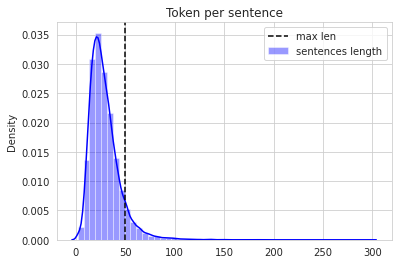

In [ ]:
sns.distplot(sentences_len, hist=True, kde=True, color="b", label="sentences length")
plt.axvline(x=max_seq_len, color="k", linestyle="--", label="max len")
plt.title("Token per sentence")
plt.legend()
plt.show()

In [ ]:
sent_less_than_msl = [s for s in docs_train.sentences if len(s) <= 50]
perc_sent = round(len(sent_less_than_msl) / len(docs_train.sentences) * 100)
print("The", perc_sent,"%", "of sentences has less or equal than 50 tokens.")

The 92 % of sentences has less or equal than 50 tokens.


# ELMO EMBEDDINGS FROM LM


In [ ]:
%%capture
# TensorFlow Hub is a repository of trained machine learning models
!pip install --upgrade tensorflow_hub
import tensorflow_hub as hub 

In [ ]:
#from tensorflow.keras import backend as K

In [ ]:
#sess = tf.compat.v1.Session()
#sess.run(tf.global_variables_initializer())
#sess.run(tf.tables_initializer())

In [ ]:

# Embeddings from a language model trained on the 1 Billion Word Benchmark.
#elmo_model = hub.KerasLayer("https://tfhub.dev/google/elmo/3", trainable=True, signature="tokens")

ElmoEmbeddingLayer class by https://github.com/strongio/keras-elmo

In [ ]:
#try to install keras=2.2.4 to support masking

In [ ]:
# Create a custom layer that allows us to update weights (lambda layers do not have trainable parameters!)
"""from keras.layers import Layer"
class ElmoEmbeddingLayer(Layer):
  def __init__(self, **kwargs):
    self.dimensions = 1024
    self.trainable = True
    super(ElmoEmbeddingLayer, self).__init__(**kwargs)

  def build(self, input_shape):
    self.elmo = hub.Module('https://tfhub.dev/google/elmo/2', trainable=self.trainable,
                           name="{}_module".format(self.name))

    self._trainable_weights += tf.compat.v1.trainable_variables(scope="^elmo_module/.*")
    super(ElmoEmbeddingLayer, self).build(input_shape)

  def call(self, x, mask=None):
    result = self.elmo(inputs={"tokens": tf.squeeze(tf.cast(x, tf.string)),
                              "sequence_len": tf.constant([max_seq_len]*batch_size)
                              },
                      signature="tokens",
                      as_dict=True)["elmo"]
    print(result)
    return result

# Check this: https://www.tensorflow.org/guide/keras/masking_and_padding
  def compute_mask(self, inputs, mask=None):
    return tf.math.not_equal(inputs, 'PAD')

  #def compute_mask(self, inputs, mask=None):
   # return tf.not_equal(inputs, "PAD")

  def compute_output_shape(self, input_shape):
    return input_shape[0], max_seq_len, self.dimensions"""

'from keras.layers import Layer"\nclass ElmoEmbeddingLayer(Layer):\n  def __init__(self, **kwargs):\n    self.dimensions = 1024\n    self.trainable = True\n    super(ElmoEmbeddingLayer, self).__init__(**kwargs)\n\n  def build(self, input_shape):\n    self.elmo = hub.Module(\'https://tfhub.dev/google/elmo/2\', trainable=self.trainable,\n                           name="{}_module".format(self.name))\n\n    self._trainable_weights += tf.compat.v1.trainable_variables(scope="^elmo_module/.*")\n    super(ElmoEmbeddingLayer, self).build(input_shape)\n\n  def call(self, x, mask=None):\n    result = self.elmo(inputs={"tokens": tf.squeeze(tf.cast(x, tf.string)),\n                              "sequence_len": tf.constant([max_seq_len]*batch_size)\n                              },\n                      signature="tokens",\n                      as_dict=True)["elmo"]\n    print(result)\n    return result\n\n# Check this: https://www.tensorflow.org/guide/keras/masking_and_padding\n  def compute_mas

In [ ]:
from keras.layers import Layer
class ElmoEmbeddingLayer(Layer):
    def __init__(self, **kwargs):
      self.dimensions = 1024
      self.trainable=True
      super(ElmoEmbeddingLayer, self).__init__(**kwargs)

    def build(self, input_shape):
      self.elmo = hub.Module('https://tfhub.dev/google/elmo/2', trainable=self.trainable,
                               name="{}_module".format(self.name))

      self.trainable_weights += K.tf.trainable_variables(scope="^{}_module/.*".format(self.name))
      super(ElmoEmbeddingLayer, self).build(input_shape)

    def call(self, x, mask=None):
      result = self.elmo(inputs={"tokens": tf.squeeze(tf.cast(x, tf.string)),
                              "sequence_len": tf.constant([max_seq_len]*batch_size)
                              },
                      signature="tokens",
                      as_dict=True)["elmo"]
    
      return result

    def compute_output_shape(self, input_shape):
      return (input_shape[0], max_seq_len, self.dimensions)

In [ ]:
from keras import backend as K

In [ ]:
"""from keras.engine import Layer"""
"""class ElmoEmbeddingLayer(Layer):
    def __init__(self, **kwargs):
      self.dimensions = 1024
      self.trainable = True
      super(ElmoEmbeddingLayer, self).__init__(**kwargs)

    def build(self, input_shape):
      self.elmo = hub.KerasLayer("https://tfhub.dev/google/elmo/3", signature="tokens", name="{}_module".format(self.name))
      self._trainable_weights += tf.compat.v1.trainable_variables(scope="^{}_module/.*".format(self.name))
      super(ElmoEmbeddingLayer, self).build(input_shape)

    def call(self, x, mask=None):
      result = self.elmo(inputs={"tokens": tf.squeeze(tf.cast(x, tf.string)),
                              "sequence_len": tf.constant( [max_seq_len]*batch_size)
                              })
      return result

    def compute_mask(self, inputs, mask=None):
      return K.not_equal(inputs, '')

    def compute_output_shape(self, input_shape):
      return (input_shape[0], max_seq_len, self.dimensions)"""

'class ElmoEmbeddingLayer(Layer):\n    def __init__(self, **kwargs):\n      self.dimensions = 1024\n      self.trainable = True\n      super(ElmoEmbeddingLayer, self).__init__(**kwargs)\n\n    def build(self, input_shape):\n      self.elmo = hub.KerasLayer("https://tfhub.dev/google/elmo/3", signature="tokens", name="{}_module".format(self.name))\n      self._trainable_weights += tf.compat.v1.trainable_variables(scope="^{}_module/.*".format(self.name))\n      super(ElmoEmbeddingLayer, self).build(input_shape)\n\n    def call(self, x, mask=None):\n      result = self.elmo(inputs={"tokens": tf.squeeze(tf.cast(x, tf.string)),\n                              "sequence_len": tf.constant( [max_seq_len]*batch_size)\n                              })\n      return result\n\n    def compute_mask(self, inputs, mask=None):\n      return K.not_equal(inputs, \'\')\n\n    def compute_output_shape(self, input_shape):\n      return (input_shape[0], max_seq_len, self.dimensions)'

The output is a 3 dimensional tensor of shape (training samples, maximum length, length of the ELMo vector).

From StackOverFlow:
*Logging message comes up due to the way how hub.Module calls tf.train.import_meta_graph but handles restoring variables by itself.*

# PREPROCESSING FOR TRAINING

Before feeding the data to the model we need to further preprocess the text. In order to feed the data to the Bi-LSTM model, we need to ensure that all text should be of the same length. The method sequence pad_sequences() and variable max_seq_len are used for this purpose. The text which are shorter than fixed max_seq_len value are padded to get them to the same length, whereas text which are longer than max_seq_len are truncated. Then, we use the TextVectorization layer from tf as text encoder. This allows to transforms a sequences of strings into a list of token indices. Every token in a sequence is mapped to a corresponding integer ID. This saves a lot of memory.


We're gonna create two different Input, one for ELMoEmbeddingLayer (string) and the other one for the tf Embedding layer (integer).

In [ ]:
# Padding sentences to the max_seq_len

X_train_padded = docs_train.pad_list_of_sents(max_seq_len)
X_test_padded =  docs_test.pad_list_of_sents(max_seq_len)
X_dev_padded =  docs_dev.pad_list_of_sents(max_seq_len)

In [ ]:
X_train_padded[0]

array(['DPP6', 'as', 'a', 'candidate', 'gene', 'for', 'neuroleptic', '-',
       'induced', 'tardive', 'dyskinesia', '.', 'PAD', 'PAD', 'PAD',
       'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD',
       'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD',
       'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD',
       'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD'],
      dtype=object)

In [ ]:
# Vocabulary Key:Tag -> Value:ID_tag & Vocabulary Key:ID_tag -> Value:Tag
tag2idx, idx2tag = docs_train.from_labels_2_idx()

In [ ]:
# Padding and encoding the target variable
y_train = docs_train.padded_and_encoded_labels(tag2idx, max_seq_len)
y_test = docs_test.padded_and_encoded_labels(tag2idx, max_seq_len)
y_dev = docs_dev.padded_and_encoded_labels(tag2idx, max_seq_len)

In [ ]:
# Decoding one-hot vectors
y_train = np.argmax(y_train, axis = -1)
y_test = np.argmax(y_test, axis = -1)
y_dev = np.argmax(y_dev, axis = -1)

In [ ]:
word2idx, idx2word = docs_train.from_word_2_idx() 

In [ ]:
word2idx["PAD"]

0

In [ ]:
# Extract the vocabulary
voc = idx2word.values()

In [ ]:
print("The word 'cell' is identified by the index: {}".format(word2idx["cell"]))
print("The labels 'B-Chemical' is identified by the index: {}".format(tag2idx["B-Chemical"]))

The word 'cell' is identified by the index: 36754
The labels 'B-Chemical' is identified by the index: 2


In [ ]:
X_train_elmo = X_train_padded

In [ ]:
X_train = [[word2idx[w] for w in s] for s in X_train_padded]

In [ ]:
voc = list(idx2word.values())

In [ ]:
voc_test = set(docs_test.tokens)

In [ ]:
voc_dev = set(docs_dev.tokens)

In [ ]:
not_in_voc = [w for w in voc_test if w not in voc]

In [ ]:
not_in_voc_dev = [w for w in voc_dev if w not in voc]

In [ ]:
# Words in test that are not in vocabulary
len(not_in_voc)

16276

In [ ]:
new_X_test = []
for s in X_test_padded:
  temp = []
  for w in s:
    if w in not_in_voc:
      w1 = w.replace(w, "UNK")
    else: 
      w1 = w
    temp.append(w1)
  new_X_test.append(temp)

In [ ]:
new_X_dev = []
for s in X_dev_padded:
  temp = []
  for w in s:
    if w in not_in_voc_dev:
      w1 = w.replace(w, "UNK")
    else: 
      w1 = w
    temp.append(w1)
  new_X_dev.append(temp)

In [ ]:
new_X_test1 = [[word2idx[w] for w in s] for s in new_X_test] # For standard Emb

In [ ]:
new_X_dev1 = [[word2idx[w] for w in s] for s in new_X_dev] # FOr standard Emb

In [ ]:
X_test_elmo = new_X_test
X_dev_elmo = new_X_dev

In [ ]:
batch_size = 32
epochs = 10

In [ ]:
# Since we have 32 as the batch size, feeding the network must be in chunks that are all multiples of 32:
X_train = X_train[:958 * batch_size]
X_val = new_X_dev1[:957 * batch_size]
X_train_elmo = X_train_elmo[:958 * batch_size]
X_val_elmo = X_dev_elmo[:957 * batch_size]
y_train = y_train[:958 * batch_size]
y_val = y_dev[:957 * batch_size]

# IMPLEMENTING MODEL ARCHITECTURE

Model Architecture 

In [ ]:
from keras.optimizers import SGD, Adam, RMSprop
from keras.models import Model
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, concatenate, Dropout, Bidirectional, Input
from keras.layers import add
from keras_contrib.layers import CRF
from keras_contrib.losses import crf_loss
from keras_contrib.metrics import crf_viterbi_accuracy

#from tf2crf import CRF, ModelWithCRFLoss

def build_model(opt=None):
  elmo_input = keras.Input(shape=(max_seq_len,), dtype=tf.string) # for Elmo
  emb_input = keras.Input(shape=(max_seq_len,), dtype='int32')

  # Output Layers
  emb_output_layer = Embedding(input_dim=len(word2idx)+1, output_dim=300, mask_zero=True)(emb_input)
  elmo_output_layer = ElmoEmbeddingLayer()(elmo_input)
  #embedding_elmo = Lambda(ElmoEmbedding, output_shape=(batch_size,1024))(elmo_input)
  #spd = SpatialDropout1D(0.3)(x) 
  #embedding_elmo = tf.keras.layers.Lambda(ElmoEmbedding, output_shape=(max_seq_len,1024))(elmo_input)
  x = concatenate([emb_output_layer, elmo_output_layer])
  x = Dropout(0.5)(x)
  model = Bidirectional(LSTM(units=256, return_sequences=True, recurrent_dropout=0.3, dropout=0.3))(x)
  model = Bidirectional(LSTM(units=125, return_sequences=True, recurrent_dropout=0.3, dropout=0.3))(model)
  model = Dense(65, activation="relu")(model)
  crf = CRF(len(tag2idx), sparse_target = True)  # CRF layer, n_tags+1(PAD)
  out = crf(model)

  model = Model([elmo_input, emb_input], out)

  if opt:
    opt = opt
  else:
    opt = Adam()
 
  model.compile(optimizer=opt, loss=crf_loss, metrics=[crf_viterbi_accuracy])
  print(model.summary())
  return model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor="val_loss", patience=2)

In [ ]:
def ignoring_padding(y_pred,y_test):
  """This function allows to compare predicted labels with true labels discarding padding"""
  y_pred = np.argmax(y_pred, -1)
  real_pred = []
  y_test_nozeroes = [[l for l in s if l != 0] for s in y_test] # Delete padding label in the original sentences
  for s, s1 in zip(y_pred, y_test_nozeroes):
    s = s.tolist() 
    real_s =  s[:len(s1)] # Delete padding from the predicted sentences
    real_pred.append(real_s)
  pred_tag = [[idx2tag[i] for i in row] for row in real_pred]
  y_test_tag = [[idx2tag[i] for i in row] for row in y_test_nozeroes]
  return pred_tag, y_test_tag

In [ ]:
%%capture
!pip3 install seqeval

In [ ]:
from keras.callbacks import Callback
from seqeval.metrics import f1_score

class Metrics(Callback):
    """Custom F1 metric to look after the performance on the validation set during the training"""
    def __init__(self, validation):   
        super(Metrics, self).__init__()
        self.validation = validation    
            
        print('validation shape', len(self.validation[0][0]))
        
    def on_train_begin(self, logs={}):        
        self.val_f1s = []
     
    def on_epoch_begin(self, epoch, logs={}):
        val_targ = self.validation[1]
        val_targ1 = val_targ.reshape((val_targ.shape[0], val_targ.shape[1]))
        val_predict = self.model.predict(self.validation[0])
        y_true, y_hat = ignoring_padding(val_predict, val_targ1)
        val_f1 = f1_score(y_true, y_hat)
        
        
        self.val_f1s.append(round(val_f1, 6))
        
 
        print(f' — val_f1: {val_f1} ')

In [ ]:
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)
y_val = y_val.reshape((y_val.shape[0], y_val.shape[1], 1))

In [ ]:
# Customised callbacks
mycallbacks = [early_stopping]

In [ ]:
# Stop WARNINGS output
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# TRAINING

In [ ]:
dir_output = "/content/drive/MyDrive/BIO-NER-project/ELMO-bi-lstm-crf-BC4CHEMD.h5"

In [ ]:
model = build_model(RMSprop())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 50, 300)      12159000    input_4[0][0]                    
__________________________________________________________________________________________________
elmo_embedding_layer_2 (ElmoEmb (None, 50, 1024)     4           input_3[0][0]                    
__________________________________________________________________________________________________
concatenat

In [ ]:
%%time
# Fit network - F1-score is measured on the validation data
history = model.fit([X_train_elmo, np.array(X_train)],y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=([X_val_elmo, np.array(X_val)], y_val), callbacks = mycallbacks)

Train on 30656 samples, validate on 30624 samples
Epoch 1/10
30656/30656 [==============================] - 906s 30ms/step - loss: 1.8356 - crf_viterbi_accuracy: 0.9686 - val_loss: 1.8233 - val_crf_viterbi_accuracy: 0.9767
Epoch 2/10
30656/30656 [==============================] - 891s 29ms/step - loss: 1.7919 - crf_viterbi_accuracy: 0.9876 - val_loss: 1.8204 - val_crf_viterbi_accuracy: 0.9791
Epoch 3/10
30656/30656 [==============================] - 890s 29ms/step - loss: 1.7835 - crf_viterbi_accuracy: 0.9916 - val_loss: 1.8270 - val_crf_viterbi_accuracy: 0.9819
Epoch 4/10
30656/30656 [==============================] - 896s 29ms/step - loss: 1.7801 - crf_viterbi_accuracy: 0.9934 - val_loss: 1.8194 - val_crf_viterbi_accuracy: 0.9795
Epoch 5/10
30656/30656 [==============================] - 900s 29ms/step - loss: 1.7780 - crf_viterbi_accuracy: 0.9944 - val_loss: 1.8207 - val_crf_viterbi_accuracy: 0.9801
Epoch 6/10
30656/30656 [==============================] - 900s 29ms/step - loss: 1.77

In [ ]:
#model.summary()

In [ ]:
model.save_weights(dir_output)

Output = viterbi_sequence, inputs(the output of the previous layer), sequence_lengths (mask), self.transitions (crf transmission parameters)

# LEARNING CURVES

In [ ]:
#history.history

In [ ]:
epochs = len(history.epoch)

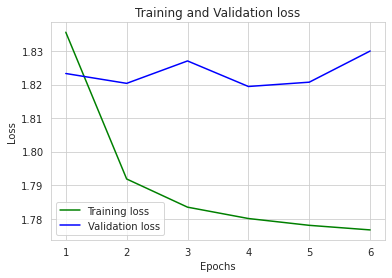

In [ ]:
loss_train = history.history["loss"]
loss_val = history.history['val_loss']
epochs = range(1,epochs+1)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

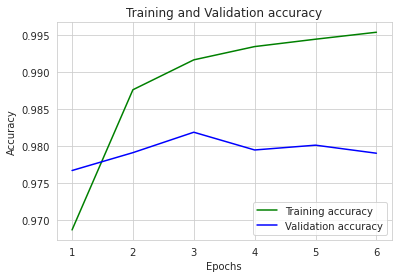

In [ ]:
loss_train = history.history["crf_viterbi_accuracy"]
loss_val = history.history['val_crf_viterbi_accuracy']
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# PREDICTION AND EVALUATION

In [ ]:
#model.built = True 

In [ ]:
model.load_weights(dir_output)

In [ ]:
X_test_elmo = X_test_elmo[:57*batch_size]
X_test_emb = new_X_test1[:57*batch_size]
y_test = y_test[:57*batch_size]

In [ ]:
%%time
y_pred = model.predict([np.array(X_test_elmo), np.array(X_test_emb)])

CPU times: user 28 s, sys: 2.84 s, total: 30.9 s
Wall time: 20.9 s


# REPORT

In [ ]:
y_hat, y_true = ignoring_padding(y_pred, y_test)

In [ ]:
from seqeval.metrics import classification_report
from seqeval.scheme import IOB2

print('\033[1m' + "Classification report for #1 model without LR optimization: ")
print('\033[0m')
print(classification_report(y_true, y_hat))

Classification report for #1 model without LR optimization: 

              precision    recall  f1-score   support

    Chemical       0.77      0.87      0.82      1567

   micro avg       0.77      0.87      0.82      1567
   macro avg       0.77      0.87      0.82      1567
weighted avg       0.77      0.87      0.82      1567



In [ ]:
print("F1-score(relaxed): {:0.3}".format(f1_score(y_true, y_hat, average = "weighted")))

F1-score(relaxed): 0.816


In [ ]:
from seqeval.scheme import IOB2
print('\033[1m' + "Classification report for #1 model without LR optimization (exact match): ")
print('\033[0m')
print(classification_report(y_true, y_hat, scheme=IOB2, mode="strict"))

Classification report for #1 model without LR optimization (exact match): 

              precision    recall  f1-score   support

    Chemical       0.77      0.87      0.82      1567

   micro avg       0.77      0.87      0.82      1567
   macro avg       0.77      0.87      0.82      1567
weighted avg       0.77      0.87      0.82      1567



In [ ]:

print("F1-score: {:0.3}".format(f1_score(y_true, y_hat, average = "weighted", scheme=IOB2, mode="strict")))

F1-score: 0.816


# COMPARE RESULTS

In [ ]:
i = 18  #prendi il chunck di frasi da 390 a 390+32
p = model.predict([np.array(X_test_elmo[i:i+batch_size]), np.array(X_test_emb[i:i+batch_size])])[0] 
p = np.argmax(p, axis=-1)

In [ ]:
X_test1=X_test_elmo
y_test1=y_test
print("{:15} ({:5}): {}".format("Word", "Pred", "True"))
print("="*45)
for w, true, pred in zip(X_test1[i], y_test1[i], p):
    if w != "PAD":
      print("{:15}:{:15} {:5}".format(w, idx2tag[pred], idx2tag[true]))

Word            (Pred ): True
Endothelial    :O               O    
nitric         :B-Chemical      B-Chemical
oxide          :I-Chemical      I-Chemical
synthase       :O               O    
genotypes      :O               O    
and            :O               O    
haplotypes     :O               O    
modify         :O               O    
the            :O               O    
responses      :O               O    
to             :O               O    
sildenafil     :B-Chemical      B-Chemical
in             :O               O    
patients       :O               O    
with           :O               O    
erectile       :O               O    
dysfunction    :O               O    
.              :O               O    


# TUNING LEARNING RATE

LRFinder implements a Keras Callback which tracks the loss associated with a learning rate varied linearly over a defined range. Implementation by https://gist.github.com/jeremyjordan

In [ ]:
from keras.callbacks import Callback

In [ ]:
"""from keras.callbacks import Callback
import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt

class LRFinder(Callback):
  
    Up-to date version: https://github.com/WittmannF/LRFinder
    Example of usage:
        from keras.models import Sequential
        from keras.layers import Flatten, Dense
        from keras.datasets import fashion_mnist
        !git clone https://github.com/WittmannF/LRFinder.git
        from LRFinder.keras_callback import LRFinder
        # 1. Input Data
        (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
        mean, std = X_train.mean(), X_train.std()
        X_train, X_test = (X_train-mean)/std, (X_test-mean)/std
        # 2. Define and Compile Model
        model = Sequential([Flatten(),
                            Dense(512, activation='relu'),
                            Dense(10, activation='softmax')])
        model.compile(loss='sparse_categorical_crossentropy', \
                      metrics=['accuracy'], optimizer='sgd')
        # 3. Fit using Callback
        lr_finder = LRFinder(min_lr=1e-4, max_lr=1)
        model.fit(X_train, y_train, batch_size=128, callbacks=[lr_finder], epochs=2)
    
    def __init__(self, min_lr, max_lr, mom=0.9, stop_multiplier=None, 
                 reload_weights=True, batches_lr_update=5):
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.mom = mom
        self.reload_weights = reload_weights
        self.batches_lr_update = batches_lr_update
        if stop_multiplier is None:
            self.stop_multiplier = -20*self.mom/3 + 10 # 4 if mom=0.9
                                                       # 10 if mom=0
        else:
            self.stop_multiplier = stop_multiplier
        
    def on_train_begin(self, logs={}):
        p = self.params
        try:
            n_iterations = p['epochs']*p['samples']//p['batch_size']
        except:
            n_iterations = p['steps']*p['epochs']
            
        self.learning_rates = np.geomspace(self.min_lr, self.max_lr, \
                                           num=n_iterations//self.batches_lr_update+1)
        self.losses=[]
        self.iteration=0
        self.best_loss=0
        if self.reload_weights:
            self.model.save_weights('tmp.hdf5')
        
    
    def on_batch_end(self, batch, logs={}):
        loss = logs.get('loss')
        
        if self.iteration!=0: # Make loss smoother using momentum
            loss = self.losses[-1]*self.mom+loss*(1-self.mom)
        
        if self.iteration==0 or loss < self.best_loss: 
                self.best_loss = loss
                
        if self.iteration%self.batches_lr_update==0: # Evaluate each lr over 5 epochs
            
            if self.reload_weights:
                self.model.load_weights('tmp.hdf5')
          
            lr = self.learning_rates[self.iteration//self.batches_lr_update]            
            K.set_value(self.model.optimizer.lr, lr)

            self.losses.append(loss)            

        if loss > self.best_loss*self.stop_multiplier: # Stop criteria
            self.model.stop_training = True
                
        self.iteration += 1
    
    def on_train_end(self, logs=None):
        if self.reload_weights:
                self.model.load_weights('tmp.hdf5')
                
        plt.figure(figsize=(12, 6))
        plt.plot(self.learning_rates[:len(self.losses)], self.losses)
        plt.xlabel("Learning Rate")
        plt.ylabel("Loss")
        plt.xscale('log')
        plt.show()
       
"""

'from keras.callbacks import Callback\nimport keras.backend as K\nimport numpy as np\nimport matplotlib.pyplot as plt\n\nclass LRFinder(Callback):\n  \n    Up-to date version: https://github.com/WittmannF/LRFinder\n    Example of usage:\n        from keras.models import Sequential\n        from keras.layers import Flatten, Dense\n        from keras.datasets import fashion_mnist\n        !git clone https://github.com/WittmannF/LRFinder.git\n        from LRFinder.keras_callback import LRFinder\n        # 1. Input Data\n        (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()\n        mean, std = X_train.mean(), X_train.std()\n        X_train, X_test = (X_train-mean)/std, (X_test-mean)/std\n        # 2. Define and Compile Model\n        model = Sequential([Flatten(),\n                            Dense(512, activation=\'relu\'),\n                            Dense(10, activation=\'softmax\')])\n        model.compile(loss=\'sparse_categorical_crossentropy\',                  

In [ ]:
"""# Get an instance of LRTest class
lr_finder = LRFinder(min_lr=1e-4, max_lr=1)

# Build the model again
model2 = build_model(RMSprop())

# Perform the LR range test 
history = model2.fit([X_train_elmo, np.array(X_train)],y_train, epochs=5, batch_size=batch_size, verbose=1, validation_data=([X_val_elmo, np.array(X_val)], y_val), callbacks=[lr_finder])"""

'# Get an instance of LRTest class\nlr_finder = LRFinder(min_lr=1e-4, max_lr=1)\n\n# Build the model again\nmodel2 = build_model(RMSprop())\n\n# Perform the LR range test \nhistory = model2.fit([X_train_elmo, np.array(X_train)],y_train, epochs=5, batch_size=batch_size, verbose=1, validation_data=([X_val_elmo, np.array(X_val)], y_val), callbacks=[lr_finder])'

# TRAIN THE MODEL WITH OPTIMAL LR

In [ ]:
# Build the model with the optimal lr
#model3 = build_model(RMSprop(lr=10**-3.0))

# Train the model
#model3.fit([X_train_elmo, np.array(X_train)],y_train, epochs=5, batch_size=batch_size, verbose=1, validation_data=([X_val_elmo, np.array(X_val)], y_val), callbacks=mycallbacks)

In [ ]:
y_pred = model.predict([np.array(X_test_elmo), np.array(X_test_emb)])

In [ ]:
y_pred = model.predict([np.array(X_test_elmo), np.array(X_test_emb)])

In [ ]:
%%time
y_hat, y_true = ignoring_padding(y_pred, y_test)

CPU times: user 49.1 ms, sys: 1.13 ms, total: 50.3 ms
Wall time: 52 ms


# REPORT2

In [ ]:
print('\033[1m' + "Classification report for #2 model with LR optimization: ")
print('\033[0m')
print(classification_report(y_true, y_hat))

Classification report for #2 model with LR optimization: 

              precision    recall  f1-score   support

    Chemical       0.77      0.87      0.82      1567

   micro avg       0.77      0.87      0.82      1567
   macro avg       0.77      0.87      0.82      1567
weighted avg       0.77      0.87      0.82      1567



In [ ]:
print("F1-score(relaxed): {:0.3}".format(f1_score(y_true, y_hat, average = "weighted")))

F1-score(relaxed): 0.816


In [ ]:
print('\033[1m' + "Classification report for #1 model without LR optimization (exact match): ")
print('\033[0m')
print(classification_report(y_true, y_hat, scheme=IOB2, mode="strict"))

Classification report for #1 model without LR optimization (exact match): 

              precision    recall  f1-score   support

    Chemical       0.77      0.87      0.82      1567

   micro avg       0.77      0.87      0.82      1567
   macro avg       0.77      0.87      0.82      1567
weighted avg       0.77      0.87      0.82      1567



In [ ]:
print("F1-score: {:0.3}".format(f1_score(y_true, y_hat, average = "weighted", scheme=IOB2, mode="strict")))

F1-score: 0.816


In [ ]:
import sys

print('Saving classification report on file...')

original_stdout = sys.stdout 

with open('/content/drive/MyDrive/output.txt', 'a') as f:
  sys.stdout = f # Change the standard output to the file we created.
  print('\033[1m' + "Classification report ELMO+Bi-LSTM+CRF for BC4CHEMD dataset: ")
  print('\033[0m')
  print(classification_report(y_true, y_hat))
  sys.stdout = original_stdout # Reset the standard output to its original value
print("Done.")

Saving classification report on file...
Done.
